# 0.0 Importações e Bibliotecas

In [1]:
# !pip install inflection
# !pip install xgboost
# !pip install lightgbm
# !pip install category_encoders

In [2]:
import pandas as pd
import inflection
import seaborn as sns

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn import model_selection as ms
from sklearn import metrics

from xgboost import XGBClassifier
from sklearn import ensemble as en
from lightgbm import LGBMClassifier
from category_encoders import target_encoder

# 0.1 Carregamento dos Dados

In [3]:
train_raw = pd.read_csv('/work/train.csv')
test_raw = pd.read_csv('/work/test.csv')

In [4]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

X = train_raw.drop('Reserva Cancelada', axis=1)
y = train_raw['Reserva Cancelada'].copy()

# Split data into train and test
x_train, x_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.20, random_state=42)

df1 = pd.concat([x_train, y_train], axis=1)

# 1.0 Descrição dos dados

In [5]:
df1.head()

,id,Classificação do hotel,Meses da reserva até o check-in,Número de pernoites reservadas,Número de hospedes,Regime de alimentação,Nacionalidade,Forma de Reserva,Já se hospedou anterioremente,Tipo do quarto reservado,Reserva feita por agência de turismo,Reserva feita por empresa,Reserva com Estacionamento,Reserva com Observações,Reserva Cancelada
2077,96971,4 estrelas,1,3,1.000,Café da manha,Spain,B2B,Sim,Amethyst,Não,Sim,Sim,1 a 3,0
44973,84626,4 estrelas,1,4,1.000,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Sim,Nenhuma,0
45954,99178,4 estrelas,1,0,1.000,Sem refeicao,Spain,Agência,Sim,Amethyst,Sim,Não,Não,Nenhuma,0
68505,96488,4 estrelas,7,7,2.000,Café da manha,Israel,Agência,Não,Green Emerald,Sim,Não,Não,1 a 3,0
9626,118201,4 estrelas,1,1,2.000,Café da manha,South Korea,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,0


## 1.1 Rename Columns

In [6]:
old_cols = df1.columns
snakecase = lambda x : inflection.parameterize(x, separator='_')
cols = list(map(snakecase, old_cols))
df1.columns = cols


old_cols = x_test.columns
snakecase = lambda x : inflection.parameterize(x, separator='_')
cols = list(map(snakecase, old_cols))
x_test.columns = cols


old_cols = test_raw.columns
snakecase = lambda x : inflection.parameterize(x, separator='_')
cols = list(map(snakecase, old_cols))
test_raw.columns = cols

# 1.2 Data Dimension

In [7]:
df1.shape

(57727, 15)

# 1.3 Data Types

In [8]:
df1.dtypes

id                                        int64
classificacao_do_hotel                   object
meses_da_reserva_ate_o_check-in           int64
numero_de_pernoites_reservadas            int64
numero_de_hospedes                      float64
regime_de_alimentacao                    object
nacionalidade                            object
forma_de_reserva                         object
ja_se_hospedou_anterioremente            object
tipo_do_quarto_reservado                 object
reserva_feita_por_agencia_de_turismo     object
reserva_feita_por_empresa                object
reserva_com_estacionamento               object
reserva_com_observacoes                  object
reserva_cancelada                         int64
dtype: object

# 1.4 Check NA

In [9]:
df1.isna().sum()

id                                        0
classificacao_do_hotel                    0
meses_da_reserva_ate_o_check-in           0
numero_de_pernoites_reservadas            0
numero_de_hospedes                        2
regime_de_alimentacao                     0
nacionalidade                           887
forma_de_reserva                          0
ja_se_hospedou_anterioremente             0
tipo_do_quarto_reservado                  0
reserva_feita_por_agencia_de_turismo      0
reserva_feita_por_empresa                 0
reserva_com_estacionamento                0
reserva_com_observacoes                   0
reserva_cancelada                         0
dtype: int64

In [10]:
# Train data
median_number_customers = df1['numero_de_hospedes'].median()
df1['numero_de_hospedes'].fillna(median_number_customers, inplace=True)

df1['nacionalidade'].fillna('desconhecido', inplace=True)

# Test data
x_test['numero_de_hospedes'].fillna(median_number_customers, inplace=True)

x_test['nacionalidade'].fillna('desconhecido', inplace=True)

# Validation data
test_raw['numero_de_hospedes'].fillna(median_number_customers, inplace=True)

test_raw['nacionalidade'].fillna('desconhecido', inplace=True)

In [11]:
df1['numero_de_hospedes'] = df1['numero_de_hospedes'].astype('int64')

# 1.5 Descriptive Statistical

In [12]:
df1.describe()

,id,meses_da_reserva_ate_o_check-in,numero_de_pernoites_reservadas,numero_de_hospedes,reserva_cancelada
count,57727.000,57727.000,57727.000,57727.000,57727.000
mean,60037.392,7.210,15.781,14.134,0.372
std,34755.892,26.106,97.536,96.051,0.483
min,1.000,1.000,0.000,0.000,0.000
25%,29909.000,1.000,2.000,2.000,0.000
50%,59977.000,3.000,3.000,2.000,0.000
75%,90312.500,6.000,4.000,2.000,1.000
max,120261.000,311.000,1172.000,1153.000,1.000


# 2.0 Feature Engineering

In [13]:
df2 = df1.copy()

## 2.1 Hipóteses

1. 
2. 
3. 
4. 
5. 
6. 
7. 
8. 
10. 

## 2.2 Feature Engineering

In [14]:
df2.head()

,id,classificacao_do_hotel,meses_da_reserva_ate_o_check-in,numero_de_pernoites_reservadas,numero_de_hospedes,regime_de_alimentacao,nacionalidade,forma_de_reserva,ja_se_hospedou_anterioremente,tipo_do_quarto_reservado,reserva_feita_por_agencia_de_turismo,reserva_feita_por_empresa,reserva_com_estacionamento,reserva_com_observacoes,reserva_cancelada
2077,96971,4 estrelas,1,3,1,Café da manha,Spain,B2B,Sim,Amethyst,Não,Sim,Sim,1 a 3,0
44973,84626,4 estrelas,1,4,1,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Sim,Nenhuma,0
45954,99178,4 estrelas,1,0,1,Sem refeicao,Spain,Agência,Sim,Amethyst,Sim,Não,Não,Nenhuma,0
68505,96488,4 estrelas,7,7,2,Café da manha,Israel,Agência,Não,Green Emerald,Sim,Não,Não,1 a 3,0
9626,118201,4 estrelas,1,1,2,Café da manha,South Korea,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,0


In [15]:
df2['regime_de_alimentacao'].value_counts()

Café da manha                     44570
Café da manha e jantar             6998
Sem refeicao                       5773
Café da manha, almoco e jantar      386
Name: regime_de_alimentacao, dtype: int64

In [16]:
quality_room_map = (1- df2.groupby('tipo_do_quarto_reservado')['id'].count() / df2.shape[0])
df2['indicador_qualidade_quarto'] = df2['tipo_do_quarto_reservado'].map(quality_room_map)
df2['combo_alimentacao'] = df2['regime_de_alimentacao'].apply(lambda x: 0 if x == "Sem refeicao" else 1)

x_test['indicador_qualidade_quarto'] = x_test['tipo_do_quarto_reservado'].map(quality_room_map)
x_test['combo_alimentacao'] = x_test['regime_de_alimentacao'].apply(lambda x: 0 if x == "Sem refeicao" else 1)

test_raw['indicador_qualidade_quarto'] = test_raw['tipo_do_quarto_reservado'].map(quality_room_map)
test_raw['combo_alimentacao'] = test_raw['regime_de_alimentacao'].apply(lambda x: 0 if x == "Sem refeicao" else 1)

In [17]:
# noites em mediana por estrelas/tipo de quarto
nights_per_hotel_map = df2.groupby('tipo_do_quarto_reservado')['numero_de_pernoites_reservadas'].median()
df2['nights_per_hotel'] = df2['tipo_do_quarto_reservado'].map(nights_per_hotel_map)

x_test['nights_per_hotel'] = x_test['tipo_do_quarto_reservado'].map(nights_per_hotel_map)

test_raw['nights_per_hotel'] = test_raw['tipo_do_quarto_reservado'].map(nights_per_hotel_map)



nights_per_hotel_map = df2.groupby('classificacao_do_hotel')['numero_de_pernoites_reservadas'].mean()
df2['nights_per_hotel'] = df2['classificacao_do_hotel'].map(nights_per_hotel_map)

x_test['nights_per_hotel'] = x_test['classificacao_do_hotel'].map(nights_per_hotel_map)

test_raw['nights_per_hotel'] = test_raw['classificacao_do_hotel'].map(nights_per_hotel_map)

In [18]:
# df2['alimentacao_quarto'] = df2['forma_de_reserva'] + ' - ' + df2['classificacao_do_hotel']
# alimentacao_quarto_map = df2['alimentacao_quarto'].value_counts() / df2.shape[0]

# df2['alimentacao_quarto'] = df2['alimentacao_quarto'].map(alimentacao_quarto_map)

# x_test['alimentacao_quarto'] = x_test['forma_de_reserva'] + ' - ' + x_test['classificacao_do_hotel']
# x_test['alimentacao_quarto'] = x_test['alimentacao_quarto'].map(alimentacao_quarto_map)
# x_test['alimentacao_quarto'].fillna(x_test['alimentacao_quarto'].median(), inplace=True)

# test_raw['alimentacao_quarto'] = test_raw['forma_de_reserva'] + ' - ' + test_raw['classificacao_do_hotel']
# test_raw['alimentacao_quarto'] = test_raw['alimentacao_quarto'].map(alimentacao_quarto_map)
# test_raw['alimentacao_quarto'].fillna(test_raw['alimentacao_quarto'].median(), inplace=True)


# clients_per_type_room_map = df2.groupby('tipo_do_quarto_reservado')['numero_de_hospedes'].mean()
# df2['hospedes_por_tipo_quarto'] = df2['tipo_do_quarto_reservado'].map(clients_per_type_room_map)

# x_test['hospedes_por_tipo_quarto'] = x_test['tipo_do_quarto_reservado'].map(clients_per_type_room_map)

# test_raw['hospedes_por_tipo_quarto'] = test_raw['tipo_do_quarto_reservado'].map(clients_per_type_room_map)


# df2['hospedes_por_noite'] = df2.apply(lambda x: 0 if x['numero_de_pernoites_reservadas'] == 0 else x['numero_de_hospedes'] / x['numero_de_pernoites_reservadas'], axis=1)
# x_test['hospedes_por_noite'] = x_test.apply(lambda x: 0 if x['numero_de_pernoites_reservadas'] == 0 else x['numero_de_hospedes'] / x['numero_de_pernoites_reservadas'], axis=1)
# test_raw['hospedes_por_noite'] = test_raw.apply(lambda x: 0 if x['numero_de_pernoites_reservadas'] == 0 else x['numero_de_hospedes'] / x['numero_de_pernoites_reservadas'], axis=1)

# map_2 = df2.groupby('nacionalidade')['meses_da_reserva_ate_o_check-in'].median()

# df2['tempo_medio_por_paises'] = df2['nacionalidade'].map(map_2)

# 3.0 Filtragem dos Dados

In [19]:
df3 = df2.copy()

## 3.1 Filtragem das Linhas

## 3.2 Filtragem das Colunas

# 4.0 Análise Exploratória dos Dados (AED)

In [20]:
df4 = df3.copy()

## 4.1.1 Análise Univariada

In [21]:
df4[df4['reserva_cancelada'] == 1]

,id,classificacao_do_hotel,meses_da_reserva_ate_o_check-in,numero_de_pernoites_reservadas,numero_de_hospedes,regime_de_alimentacao,nacionalidade,forma_de_reserva,ja_se_hospedou_anterioremente,tipo_do_quarto_reservado,reserva_feita_por_agencia_de_turismo,reserva_feita_por_empresa,reserva_com_estacionamento,reserva_com_observacoes,reserva_cancelada,indicador_qualidade_quarto,combo_alimentacao,nights_per_hotel
32582,1866,5 estrelas,3,7,2,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,1 a 3,1,0.282,1,17.097
30797,47847,4 estrelas,2,3,2,Sem refeicao,Spain,Agência,Não,Amethyst,Sim,Não,Não,1 a 3,1,0.282,0,15.112
250,46598,4 estrelas,5,5,2,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1,0.282,1,15.112
43875,10653,5 estrelas,7,7,2,Café da manha,France,Agência,Não,Amethyst,Sim,Não,Não,1 a 3,1,0.282,1,17.097
14252,75448,4 estrelas,11,1,2,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1,0.282,1,15.112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64925,669,5 estrelas,11,14,3,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,1 a 3,1,0.282,1,17.097
769,12068,5 estrelas,10,5,2,Café da manha e jantar,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1,0.282,1,17.097
16023,62304,4 estrelas,5,1,2,Sem refeicao,Spain,Agência,Não,Amethyst,Sim,Não,Não,1 a 3,1,0.282,0,15.112
60263,6711,5 estrelas,1,2,4,Café da manha,Spain,Agência,Não,Topaz,Sim,Não,Não,Nenhuma,1,0.983,1,17.097


## 4.1.2 Variáveis Numéricas

## 4.1.3 Variáveis Categóricas

<AxesSubplot: xlabel='regime_de_alimentacao', ylabel='count'>

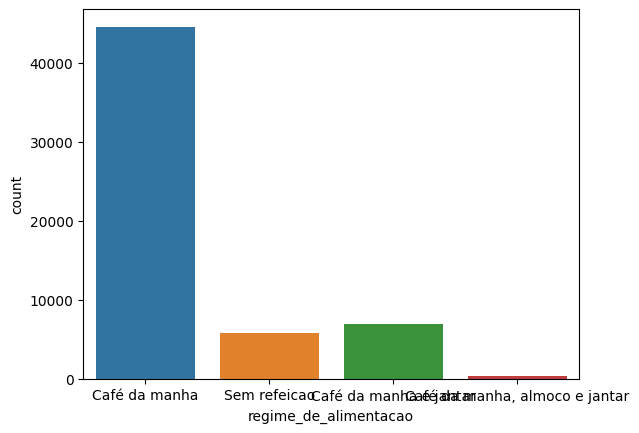

In [22]:
categorical_types = df4.select_dtypes(exclude=['int64', 'float64'])

sns.countplot(x='regime_de_alimentacao', data=df4)

## 4.1.4 Variável resposta

## 4.2.1 Análise Multivariada

## 4.2.1 Atributos Numéricos

## 4.2.2 Atributos Categóricos

# 5.0 Preparação dos dados

In [23]:
df5 = df4.copy()

## 5.1 Normalização

## 5.2 Reescalonar (Rescaling)

# 5.3 Transformação

## 5.3.1 Encoding

In [24]:
df5.dtypes

id                                        int64
classificacao_do_hotel                   object
meses_da_reserva_ate_o_check-in           int64
numero_de_pernoites_reservadas            int64
numero_de_hospedes                        int64
regime_de_alimentacao                    object
nacionalidade                            object
forma_de_reserva                         object
ja_se_hospedou_anterioremente            object
tipo_do_quarto_reservado                 object
reserva_feita_por_agencia_de_turismo     object
reserva_feita_por_empresa                object
reserva_com_estacionamento               object
reserva_com_observacoes                  object
reserva_cancelada                         int64
indicador_qualidade_quarto              float64
combo_alimentacao                         int64
nights_per_hotel                        float64
dtype: object

In [25]:
categorical_types = df5.select_dtypes(exclude=['int64', 'float64'])

categorical_types.apply(lambda x: x.unique().shape[0])

classificacao_do_hotel                    2
regime_de_alimentacao                     4
nacionalidade                           166
forma_de_reserva                          3
ja_se_hospedou_anterioremente             2
tipo_do_quarto_reservado                 10
reserva_feita_por_agencia_de_turismo      2
reserva_feita_por_empresa                 2
reserva_com_estacionamento                2
reserva_com_observacoes                   3
dtype: int64

In [26]:
le = LabelEncoder()
te = target_encoder.TargetEncoder(handle_unknown='value')

df5['regime_de_alimentacao'] = le.fit_transform(df5['regime_de_alimentacao'])
x_test['regime_de_alimentacao'] = le.transform(x_test['regime_de_alimentacao'])
test_raw['regime_de_alimentacao'] = le.transform(test_raw['regime_de_alimentacao'])

df5['classificacao_do_hotel'] = le.fit_transform(df5['classificacao_do_hotel'])
x_test['classificacao_do_hotel'] = le.transform(x_test['classificacao_do_hotel'])
test_raw['classificacao_do_hotel'] = le.transform(test_raw['classificacao_do_hotel'])

df5['nacionalidade'] = te.fit_transform(df5['nacionalidade'], df5['reserva_cancelada'])
x_test['nacionalidade'] = te.transform(x_test['nacionalidade'])
test_raw['nacionalidade'] = te.transform(test_raw['nacionalidade'])

df5['forma_de_reserva'] = le.fit_transform(df5['forma_de_reserva'])
x_test['forma_de_reserva'] = le.transform(x_test['forma_de_reserva'])
test_raw['forma_de_reserva'] = le.transform(test_raw['forma_de_reserva'])

df5['ja_se_hospedou_anterioremente'] = le.fit_transform(df5['ja_se_hospedou_anterioremente'])
x_test['ja_se_hospedou_anterioremente'] = le.transform(x_test['ja_se_hospedou_anterioremente'])
test_raw['ja_se_hospedou_anterioremente'] = le.transform(test_raw['ja_se_hospedou_anterioremente'])

df5['tipo_do_quarto_reservado'] = le.fit_transform(df5['tipo_do_quarto_reservado'])
x_test['tipo_do_quarto_reservado'] = le.transform(x_test['tipo_do_quarto_reservado'])
test_raw['tipo_do_quarto_reservado'] = le.transform(test_raw['tipo_do_quarto_reservado'])

df5['reserva_feita_por_agencia_de_turismo'] = le.fit_transform(df5['reserva_feita_por_agencia_de_turismo'])
x_test['reserva_feita_por_agencia_de_turismo'] = le.transform(x_test['reserva_feita_por_agencia_de_turismo'])
test_raw['reserva_feita_por_agencia_de_turismo'] = le.transform(test_raw['reserva_feita_por_agencia_de_turismo'])

df5['reserva_feita_por_empresa'] = le.fit_transform(df5['reserva_feita_por_empresa'])
x_test['reserva_feita_por_empresa'] = le.transform(x_test['reserva_feita_por_empresa'])
test_raw['reserva_feita_por_empresa'] = le.transform(test_raw['reserva_feita_por_empresa'])

df5['reserva_com_estacionamento'] = le.fit_transform(df5['reserva_com_estacionamento'])
x_test['reserva_com_estacionamento'] = le.transform(x_test['reserva_com_estacionamento'])
test_raw['reserva_com_estacionamento'] = le.transform(test_raw['reserva_com_estacionamento'])

df5['reserva_com_observacoes'] = le.fit_transform(df5['reserva_com_observacoes'])
x_test['reserva_com_observacoes'] = le.transform(x_test['reserva_com_observacoes'])
test_raw['reserva_com_observacoes'] = le.transform(test_raw['reserva_com_observacoes'])

# 6.0 Seleção dos Atributos

In [27]:
df6 = df5.copy()

## 6.1 Separação dos Dados para Treino e Teste

## 6.1 Escolha das Colunas / Atributos

# 7.0 Modelagem de Machine Learning

In [28]:
df7 = df5.copy()

X = df7.drop('reserva_cancelada', axis=1)
y = df7['reserva_cancelada'].copy()

## 7.1 Modelo Random Forest Classifier

In [29]:
rf_model = en.RandomForestClassifier(random_state=42)

rf_model.fit(X, y)

y_hat_rf = rf_model.predict(x_test)

metrics.f1_score(y_test, y_hat_rf, average='macro')

0.9708674535041204

0.9708674535041204

## 7.2 Modelo Extra Trees Classifier

In [30]:
et_model = en.ExtraTreesClassifier(random_state=42)

et_model.fit(X, y)

y_hat_et = et_model.predict(x_test)

metrics.f1_score(y_test, y_hat_et, average='macro')

0.965446067717007

0.9663344118202791

## 7.3 Modelo XGBoost

In [31]:
xgb_model = XGBClassifier(random_state=42)

et_model.fit(X, y)

y_hat_xgb = et_model.predict(x_test)

metrics.f1_score(y_test, y_hat_xgb, average='macro')

0.965446067717007

0.9663344118202791

## 7.4 Modelo LGBM

In [32]:
# lgbm_model = LGBMClassifier(random_state=42)

# lgbm_model.fit(X, y)

# y_hat_lgbm = lgbm_model.predict(x_test)

# metrics.f1_score(y_test, y_hat_lgbm, average='macro')

0.954888637221593

## 7.5 Modelo x

## 7.6 Avaliação dos Modelos

# 8.0 Ajuste do Modelo (Hyperparameter Fine Tuning)

In [33]:
df8 = df7.copy()

## 8.1 Busca Aleatória (Random Search)

## 8.2 Modelo Final

# 9.0 Submissão

In [34]:
df9 = df8.copy()

In [35]:
test_raw.isna().sum()

id                                      0
classificacao_do_hotel                  0
meses_da_reserva_ate_o_check-in         0
numero_de_pernoites_reservadas          0
numero_de_hospedes                      0
regime_de_alimentacao                   0
nacionalidade                           0
forma_de_reserva                        0
ja_se_hospedou_anterioremente           0
tipo_do_quarto_reservado                0
reserva_feita_por_agencia_de_turismo    0
reserva_feita_por_empresa               0
reserva_com_estacionamento              0
reserva_com_observacoes                 0
indicador_qualidade_quarto              0
combo_alimentacao                       0
nights_per_hotel                        0
dtype: int64

In [36]:
y_hat = rf_model.predict(test_raw)

In [37]:
pd.Series(y_hat, name='Reserva Cancelada')

0        0
1        1
2        0
3        1
4        0
        ..
48101    0
48102    0
48103    0
48104    1
48105    1
Name: Reserva Cancelada, Length: 48106, dtype: int64

In [38]:
test = pd.concat([test_raw, pd.Series(y_hat)], axis=1).rename(columns={0: 'Reserva Cancelada'})

# test[['id', 'Reserva Cancelada']].to_csv('/work/submit3.csv', index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1f2e6561-5818-46b0-8797-0a88d12bf58e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>